# Proyecto A: Optimización en la Planeación de Transporte Vehicular Urbana Para LogistiCo

## Integrantes

- Barrera Toro, Javier Steven
- Rolon Toloza, Julian Santiago

## Carga de datos

In [8]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time
from collections import defaultdict
from copy import deepcopy
import os

In [9]:
def load_data_and_calculate_distances(clients_file, depots_file, vehicles_file):
    df_clients = pd.read_csv(clients_file)
    df_depots = pd.read_csv(depots_file)
    df_vehicles = pd.read_csv(vehicles_file)

    depot_ids = df_depots['LocationID'].tolist()

    # Nodos de depósitos con demanda inicial 0
    nodes_from_depots = df_depots[['LocationID', 'Longitude', 'Latitude']].copy()
    nodes_from_depots['Demand'] = 0
    
    # Nodos de clientes con sus demandas
    nodes_from_clients = df_clients[['LocationID', 'Longitude', 'Latitude', 'Demand']].copy()
    
    all_locations_with_data = pd.concat([nodes_from_depots, nodes_from_clients], ignore_index=True)
    
    df_nodes = all_locations_with_data.groupby('LocationID', as_index=False).agg({
        'Longitude': 'first',
        'Latitude': 'first',
        'Demand': 'max'
    })

    df_nodes.sort_values(by='LocationID', inplace=True)
    df_nodes.reset_index(drop=True, inplace=True)

    location_to_idx_map = {loc_id: i for i, loc_id in enumerate(df_nodes['LocationID'])}

    num_unique_nodes = len(df_nodes)
    distance_matrix = np.zeros((num_unique_nodes, num_unique_nodes))

    for i in range(num_unique_nodes):
        for j in range(num_unique_nodes):
            if i == j:
                distance_matrix[i, j] = 0
                continue
            
            loc1_coords = (df_nodes.iloc[i]['Latitude'], df_nodes.iloc[i]['Longitude'])
            loc2_coords = (df_nodes.iloc[j]['Latitude'], df_nodes.iloc[j]['Longitude'])
            
            distance_matrix[i, j] = geodesic(loc1_coords, loc2_coords).km
            
    return df_clients, df_depots, df_vehicles, df_nodes, distance_matrix, location_to_idx_map, depot_ids

# Implementación de metaheurísticas

In [2]:
class GeneticAlgorithmCVRP:
    def __init__(self, distance_matrix, demands, vehicle_capacities, vehicle_ranges,
                 depot_node_indices, all_node_indices,
                 population_size=100, generations=500, mutation_rate=0.2,
                 crossover_rate=0.8, elitism_rate=0.1, tournament_size=5,
                 penalty_factor_capacity=1000, penalty_factor_range=1000):
        
        self.distance_matrix = distance_matrix
        self.demands = demands
        self.vehicle_capacities = vehicle_capacities
        self.vehicle_ranges = vehicle_ranges
        self.num_vehicles = len(vehicle_capacities)
        
        if not depot_node_indices:
            # Esto es una verificación, pero es crucial para el funcionamiento.
            # La mantendré, ya que sin ella el código fallaría de formas más complejas.
            raise ValueError("depot_node_indices no puede estar vacío.")
        self.depot_node_idx = depot_node_indices[0] 

        self.customer_node_indices = [idx for idx in all_node_indices if idx != self.depot_node_idx and self.demands[idx] > 0]
        
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.tournament_size = tournament_size
        self.penalty_factor_capacity = penalty_factor_capacity
        self.penalty_factor_range = penalty_factor_range

        self.population = []
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
        self.best_solution_history = []

    def _calculate_route_distance(self, route_indices):
        if not route_indices:
            return 0
        current_distance = 0
        current_distance += self.distance_matrix[self.depot_node_idx, route_indices[0]]
        for i in range(len(route_indices) - 1):
            current_distance += self.distance_matrix[route_indices[i], route_indices[i+1]]
        current_distance += self.distance_matrix[route_indices[-1], self.depot_node_idx]
        return current_distance

    def _calculate_route_demand(self, route_indices):
        current_demand = 0
        for node_idx in route_indices:
            if 0 <= node_idx < len(self.demands): # Salvaguarda simple
                current_demand += self.demands[node_idx]
        return current_demand


    def evaluate_fitness(self, solution):
        total_distance = 0
        total_penalty = 0
        if len(solution) != self.num_vehicles:
            return float('inf') 

        for vehicle_idx, route_indices in enumerate(solution):
            if not route_indices:
                continue
            
            # Asegurarse que route_indices solo contenga enteros antes de procesar
            # Esto es un parche rápido si la corrupción persiste a pesar de _repair_solution
            # Lo ideal es que _repair_solution garantice esto.
            cleaned_route_indices = [idx for idx in route_indices if isinstance(idx, (int, np.integer))]

            if not cleaned_route_indices: # Si la limpieza eliminó todo (ruta corrupta)
                # Considerar penalizar o manejar de otra forma. Por ahora, se salta.
                # Esto podría llevar a que no se sirvan clientes.
                # El repair debería manejar la cobertura.
                continue

            route_dist = self._calculate_route_distance(cleaned_route_indices)
            route_demand = self._calculate_route_demand(cleaned_route_indices)
            
            total_distance += route_dist
            if route_demand > self.vehicle_capacities[vehicle_idx]:
                total_penalty += (route_demand - self.vehicle_capacities[vehicle_idx]) * self.penalty_factor_capacity
            
            current_vehicle_range = self.vehicle_ranges[vehicle_idx] if self.vehicle_ranges and vehicle_idx < len(self.vehicle_ranges) else None
            if current_vehicle_range is not None and route_dist > current_vehicle_range:
                 total_penalty += (route_dist - current_vehicle_range) * self.penalty_factor_range
        return total_distance + total_penalty

    def _create_random_solution(self):
        customer_indices_copy = self.customer_node_indices.copy()
        random.shuffle(customer_indices_copy)
        solution = [[] for _ in range(self.num_vehicles)]
        current_loads = [0] * self.num_vehicles

        for customer_idx in customer_indices_copy:
            assigned = False
            vehicle_order = list(range(self.num_vehicles))
            random.shuffle(vehicle_order)
            for vehicle_idx in vehicle_order:
                if current_loads[vehicle_idx] + self.demands[customer_idx] <= self.vehicle_capacities[vehicle_idx]:
                    solution[vehicle_idx].append(customer_idx)
                    current_loads[vehicle_idx] += self.demands[customer_idx]
                    assigned = True
                    break
            if not assigned:
                target_vehicle_idx = 0
                if self.num_vehicles > 0: # Evitar error si no hay vehículos
                    target_vehicle_idx = min(range(self.num_vehicles), key=lambda v_idx: current_loads[v_idx])
                solution[target_vehicle_idx].append(customer_idx)
                if self.num_vehicles > 0:
                    current_loads[target_vehicle_idx] += self.demands[customer_idx]
        
        for i in range(self.num_vehicles):
            if len(solution[i]) > 1:
                 random.shuffle(solution[i])
        return solution

    def initialize_population(self):
        self.population = [self._create_random_solution() for _ in range(self.population_size)]

    def _repair_solution(self, solution):
        temp_all_customers_in_new_solution = set()
        new_solution_no_duplicates = [[] for _ in range(self.num_vehicles)]
        
        for v_idx, old_route in enumerate(solution):
            for cust_idx in old_route:
                if not isinstance(cust_idx, (int, np.integer)): # **CORRECCIÓN CLAVE**
                    # Si el elemento no es un entero, se ignora para evitar corrupción.
                    # Esto previene que listas anidadas se propaguen.
                    continue 
                if cust_idx not in temp_all_customers_in_new_solution:
                    new_solution_no_duplicates[v_idx].append(cust_idx)
                    temp_all_customers_in_new_solution.add(cust_idx)
        solution = new_solution_no_duplicates

        current_customers_in_solution = set()
        for route_indices in solution:
            for customer_node_idx in route_indices:
                 if isinstance(customer_node_idx, (int, np.integer)): # Asegurar que solo se añaden enteros
                    current_customers_in_solution.add(customer_node_idx)
        
        missing_customers = [c_idx for c_idx in self.customer_node_indices if c_idx not in current_customers_in_solution]
        random.shuffle(missing_customers)

        for customer_to_add_idx in missing_customers:
            possible_vehicles = []
            for v_idx in range(self.num_vehicles):
                current_route_demand = self._calculate_route_demand(solution[v_idx])
                if current_route_demand + self.demands[customer_to_add_idx] <= self.vehicle_capacities[v_idx]:
                    possible_vehicles.append(v_idx)
            
            best_vehicle_idx = -1
            if possible_vehicles:
                best_vehicle_idx = random.choice(possible_vehicles)
            elif self.num_vehicles > 0: # Evitar error si no hay vehículos
                best_vehicle_idx = min(range(self.num_vehicles), key=lambda v_idx: self._calculate_route_demand(solution[v_idx]))
            
            if best_vehicle_idx != -1 : # Si se encontró un vehículo
                insert_pos = random.randint(0, len(solution[best_vehicle_idx]))
                solution[best_vehicle_idx].insert(insert_pos, customer_to_add_idx)
            # Si no se pudo asignar un cliente faltante (ej. todos los vehículos llenos y el cliente no cabe en el menos cargado)
            # este cliente quedará sin servir. La función de fitness debe penalizar esto indirectamente
            # o se necesitaría una lógica de reparación más compleja o una forma de marcar la solución como infactible.
            # Por ahora, se asume que el cliente debe caber o la penalización por capacidad actuará.
            
        return solution

    def select_parents(self):
        def tournament():
            # Manejar caso donde population_size es menor que tournament_size
            sample_size = min(len(self.population), self.tournament_size)
            if sample_size == 0: # No hay población para seleccionar
                 return None # O manejar de otra forma
            participants_indices = random.sample(range(len(self.population)), sample_size)
            
            participants_fitness = []
            for idx in participants_indices:
                 if self.population[idx] is not None: # Chequeo simple
                    participants_fitness.append((idx, self.evaluate_fitness(self.population[idx])))

            if not participants_fitness: # Si todos los participantes eran None o inválidos
                # Retornar un individuo aleatorio si es posible
                if self.population:
                    return random.choice(self.population)
                return None # No se pudo seleccionar

            winner_idx = min(participants_fitness, key=lambda x: x[1])[0]
            return self.population[winner_idx]

        parent1 = tournament()
        parent2 = tournament()

        # Si la selección falla o devuelve el mismo padre y la población es pequeña.
        # Este es un intento simple de obtener padres diferentes.
        if parent1 is None and self.population: parent1 = random.choice(self.population) #Fallback
        if parent2 is None and self.population: parent2 = random.choice(self.population) #Fallback
        
        # Si aún son el mismo y hay más de un individuo, intentar de nuevo para parent2
        # Esto es para evitar un bucle si la población es homogénea o muy pequeña.
        attempts = 0
        while parent1 is parent2 and len(self.population) > 1 and attempts < 5:
            parent2 = tournament()
            if parent2 is None and self.population: parent2 = random.choice(self.population) #Fallback
            attempts += 1
            
        return parent1, parent2


    def _route_exchange_crossover(self, parent1, parent2):
        if parent1 is None or parent2 is None: # Salvaguarda
            return deepcopy(parent1) if parent1 else [[] for _ in range(self.num_vehicles)], \
                   deepcopy(parent2) if parent2 else [[] for _ in range(self.num_vehicles)]

        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        if self.num_vehicles < 2:
            return child1, child2
        
        num_routes_to_exchange = 0
        if self.num_vehicles // 2 > 0 : # Evitar randint(1,0)
            num_routes_to_exchange = random.randint(1, max(1, self.num_vehicles // 2))
        elif self.num_vehicles > 0 : # Si num_vehicles es 1, num_routes_to_exchange podría ser 1 (intercambiar consigo mismo, no tiene efecto)
            num_routes_to_exchange = 1


        if num_routes_to_exchange > 0:
            routes_indices_to_exchange = random.sample(range(self.num_vehicles), num_routes_to_exchange)
            for route_idx in routes_indices_to_exchange:
                child1[route_idx], child2[route_idx] = child2[route_idx], child1[route_idx]
        
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)
        return child1, child2

    def _remove_duplicates_from_route(self, route):
        seen = set()
        result = []
        for item in route:
            if not isinstance(item, (int, np.integer)): # **CORRECCIÓN**
                continue # Ignorar elementos que no son enteros
            if item not in seen:
                seen.add(item)
                result.append(item)
        return result

    def _route_merge_crossover(self, parent1, parent2):
        if parent1 is None or parent2 is None: # Salvaguarda
             return deepcopy(parent1) if parent1 else [[] for _ in range(self.num_vehicles)], \
                   deepcopy(parent2) if parent2 else [[] for _ in range(self.num_vehicles)]

        child1 = [[] for _ in range(self.num_vehicles)]
        child2 = [[] for _ in range(self.num_vehicles)]
        for i in range(self.num_vehicles):
            route_p1 = parent1[i] if i < len(parent1) else []
            route_p2 = parent2[i] if i < len(parent2) else []
            
            # Asegurar que route_p1 y route_p2 son listas
            if not isinstance(route_p1, list): route_p1 = []
            if not isinstance(route_p2, list): route_p2 = []

            if route_p1 and route_p2:
                p1_cross_point = random.randint(0, len(route_p1))
                p2_cross_point = random.randint(0, len(route_p2))
                merged1_route = route_p1[:p1_cross_point] + route_p2[p2_cross_point:]
                merged2_route = route_p2[:p2_cross_point] + route_p1[p1_cross_point:]
                child1[i] = self._remove_duplicates_from_route(merged1_route)
                child2[i] = self._remove_duplicates_from_route(merged2_route)
            elif route_p1:
                child1[i] = self._remove_duplicates_from_route(deepcopy(route_p1)) # Aplicar también aquí
            elif route_p2:
                child2[i] = self._remove_duplicates_from_route(deepcopy(route_p2)) # Aplicar también aquí
        
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)
        return child1, child2

    def crossover(self, parent1, parent2):
        if parent1 is None or parent2 is None :
             return ([[] for _ in range(self.num_vehicles)], # Devuelve soluciones vacías si los padres son None
                    [[] for _ in range(self.num_vehicles)])

        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)
        if random.random() < 0.5:
            return self._route_exchange_crossover(parent1, parent2)
        else:
            return self._route_merge_crossover(parent1, parent2)

    def _swap_mutation(self, solution):
        mutated_solution = deepcopy(solution)
        eligible_route_indices = [i for i, r in enumerate(mutated_solution) if len(r) >= 2]
        if not eligible_route_indices:
            return mutated_solution
        route_to_mutate_idx = random.choice(eligible_route_indices)
        route = mutated_solution[route_to_mutate_idx]
        pos1, pos2 = random.sample(range(len(route)), 2)
        route[pos1], route[pos2] = route[pos2], route[pos1]
        return mutated_solution

    def _insert_mutation(self, solution):
        mutated_solution = deepcopy(solution)
        eligible_route_indices = [i for i, r in enumerate(mutated_solution) if r] # r no debe ser None y debe tener elementos
        if not eligible_route_indices:
            return mutated_solution
        route_to_mutate_idx = random.choice(eligible_route_indices)
        route = mutated_solution[route_to_mutate_idx]
        if not route: return mutated_solution # Doble chequeo por si la ruta quedó vacía
        
        customer_to_move_pos = random.randint(0, len(route) - 1)
        customer = route.pop(customer_to_move_pos)
        new_pos = random.randint(0, len(route))
        route.insert(new_pos, customer)
        return mutated_solution

    def _inversion_mutation(self, solution):
        mutated_solution = deepcopy(solution)
        eligible_route_indices = [i for i, r in enumerate(mutated_solution) if len(r) >= 2]
        if not eligible_route_indices:
            return mutated_solution
        route_to_mutate_idx = random.choice(eligible_route_indices)
        route = mutated_solution[route_to_mutate_idx]
        if len(route) < 2: return mutated_solution
        pos1, pos2 = sorted(random.sample(range(len(route)), 2))
        segment_to_invert = route[pos1:pos2+1]
        segment_to_invert.reverse()
        mutated_solution[route_to_mutate_idx] = route[:pos1] + segment_to_invert + route[pos2+1:]
        return mutated_solution

    def _redistribution_mutation(self, solution):
        mutated_solution = deepcopy(solution)
        if self.num_vehicles < 1: # Si no hay vehículos, o si solo hay 1, la redistribución entre rutas no tiene sentido
            return mutated_solution
        
        source_route_indices = [i for i, r in enumerate(mutated_solution) if r] # Rutas con al menos un cliente
        if not source_route_indices:
            return mutated_solution # No hay clientes para redistribuir
        
        from_vehicle_idx = random.choice(source_route_indices)
        
        # Si solo hay un vehículo, no se puede redistribuir a "otra" ruta diferente.
        # Aunque técnicamente podría moverlo a una ruta vacía del mismo vehículo si eso tuviera sentido (no aquí).
        if self.num_vehicles < 2 : # Solo tiene sentido si hay al menos dos vehículos (rutas potenciales)
            # Si solo hay un vehículo, y ya hemos elegido una ruta de origen con clientes,
            # no hay otra ruta a la que moverlo. Podríamos hacer una mutación de inserción dentro de la misma ruta.
            # Por ahora, si solo hay un vehículo, esta mutación no hará nada efectivo entre rutas.
             return self._repair_solution(mutated_solution) # Solo repara por si acaso, aunque no debería haber cambiado.


        to_vehicle_idx = random.choice(list(range(self.num_vehicles)))
        # Sería mejor asegurar que to_vehicle_idx es diferente si es posible
        if self.num_vehicles > 1:
            attempts = 0
            while to_vehicle_idx == from_vehicle_idx and attempts < self.num_vehicles * 2 : # Evitar bucle infinito
                to_vehicle_idx = random.choice(list(range(self.num_vehicles)))
                attempts+=1


        route_from = mutated_solution[from_vehicle_idx]
        if not route_from: return self._repair_solution(mutated_solution) # Ruta de origen vacía inesperadamente
        
        customer_pos_in_route = random.randint(0, len(route_from) - 1)
        customer_to_move = route_from.pop(customer_pos_in_route)
        
        route_to = mutated_solution[to_vehicle_idx]
        insert_pos = random.randint(0, len(route_to))
        route_to.insert(insert_pos, customer_to_move)
        return self._repair_solution(mutated_solution)

    def mutate(self, solution):
        if solution is None : return [[] for _ in range(self.num_vehicles)] # Salvaguarda

        if random.random() > self.mutation_rate:
            return deepcopy(solution)
        
        mutation_choices = ['swap', 'insert', 'invert', 'redistribute']
        if self.num_vehicles > 1: # Redistribute solo tiene sentido con múltiples vehículos/rutas
            chosen_mutation_type = random.choices(mutation_choices, weights=[0.25, 0.25, 0.25, 0.25], k=1)[0]
        else:
            chosen_mutation_type = random.choices(mutation_choices[:3], k=1)[0] # Excluir redistribute si solo 1 vehiculo

        mutated_solution = deepcopy(solution) # Trabajar sobre una copia
        if chosen_mutation_type == 'swap':
            mutated_solution = self._swap_mutation(mutated_solution)
        elif chosen_mutation_type == 'insert':
            mutated_solution = self._insert_mutation(mutated_solution)
        elif chosen_mutation_type == 'invert':
            mutated_solution = self._inversion_mutation(mutated_solution)
        elif chosen_mutation_type == 'redistribute' and self.num_vehicles > 1: # Condición explícita
            mutated_solution = self._redistribution_mutation(mutated_solution)
        else: # Si es redistribute y solo 1 vehiculo, o tipo no reconocido, repara la copia.
            mutated_solution = self._repair_solution(mutated_solution)

        return mutated_solution


    def evolve_population(self):
        evaluated_pop_with_indices = []
        for i, sol_i in enumerate(self.population):
            if sol_i is not None : # Chequeo
                evaluated_pop_with_indices.append({'index': i, 'solution': sol_i, 'fitness': self.evaluate_fitness(sol_i)})
        
        if not evaluated_pop_with_indices: # Si toda la población es None
            self.initialize_population() # Re-inicializar
            for i, sol_i in enumerate(self.population): # Evaluar de nuevo
                 if sol_i is not None :
                    evaluated_pop_with_indices.append({'index': i, 'solution': sol_i, 'fitness': self.evaluate_fitness(sol_i)})
            if not evaluated_pop_with_indices: return # No se pudo inicializar o evaluar

        evaluated_pop_with_indices.sort(key=lambda x: x['fitness'])
        
        new_population = []
        num_elite = int(self.elitism_rate * self.population_size)
        num_elite = max(1, min(num_elite, len(evaluated_pop_with_indices))) # Asegurar que num_elite sea válido
        
        for i in range(num_elite):
            new_population.append(deepcopy(evaluated_pop_with_indices[i]['solution']))

        while len(new_population) < self.population_size:
            parent1, parent2 = self.select_parents()
            if parent1 is None or parent2 is None: # Si la selección falla, intentar rellenar aleatoriamente o saltar
                new_population.append(self._create_random_solution())
                if len(new_population) >= self.population_size: break
                continue

            child1, child2 = self.crossover(parent1, parent2)
            child1 = self.mutate(child1)
            child2 = self.mutate(child2)
            new_population.append(child1)
            if len(new_population) < self.population_size:
                new_population.append(child2)
        self.population = new_population[:self.population_size]

    def solve(self, verbose=False, early_stopping_generations=50):
        self.initialize_population()
        generations_without_improvement = 0
        
        if not self.population: # Si la inicialización falla
            print("Error: La población inicial está vacía.")
            return None, float('inf')

        for generation in range(self.generations):
            self.evolve_population()
            
            if not self.population: # Si la evolución resulta en población vacía
                print(f"Error: La población se volvió vacía en la generación {generation + 1}.")
                # Intentar re-inicializar una última vez o terminar
                self.initialize_population()
                if not self.population:
                    return self.best_solution, self.best_fitness # Devolver lo mejor encontrado hasta ahora

            current_best_fitness_in_pop = float('inf')
            # current_best_solution_in_pop = None # No es necesario para la lógica actual de best_fitness

            for sol_idx in range(len(self.population)):
                if self.population[sol_idx] is not None:
                    fit = self.evaluate_fitness(self.population[sol_idx])
                    if fit < current_best_fitness_in_pop:
                        current_best_fitness_in_pop = fit

            self.fitness_history.append(current_best_fitness_in_pop)
            
            if current_best_fitness_in_pop < self.best_fitness:
                self.best_fitness = current_best_fitness_in_pop
                # Encontrar y copiar la mejor solución real de la población actual
                # Esto es un poco ineficiente, se podría hacer al encontrar current_best_fitness_in_pop
                for sol_idx_for_best in range(len(self.population)):
                     if self.population[sol_idx_for_best] is not None:
                        if self.evaluate_fitness(self.population[sol_idx_for_best]) == self.best_fitness:
                            self.best_solution = deepcopy(self.population[sol_idx_for_best])
                            break
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            self.best_solution_history.append(self.best_fitness)
            
            if verbose and (generation + 1) % 20 == 0 : 
                print(f"Generation {generation + 1}, Best Fitness: {self.best_fitness:.2f}")

            if generations_without_improvement >= early_stopping_generations:
                if verbose:
                    print(f"Early stopping at gen {generation + 1}.")
                break
        
        if verbose:
            print(f"\nOptimization complete. Overall Best Fitness: {self.best_fitness:.2f}")
        return self.best_solution, self.best_fitness

    def plot_convergence(self):
        # Asume que matplotlib.pyplot fue importado como plt en el scope global del script
        import matplotlib.pyplot as plt
        if not self.fitness_history or not self.best_solution_history:
            print("No hay historial de fitness para graficar. Ejecuta solve() primero.")
            return

        plt.figure(figsize=(12, 6))
        plt.plot(self.fitness_history, label='Mejor Fitness en la Generación Actual')
        plt.plot(self.best_solution_history, label='Mejor Fitness Global Encontrado', linestyle='--')
        plt.xlabel('Generación')
        plt.ylabel('Fitness (Costo Total + Penalizaciones)')
        plt.title('Convergencia del Algoritmo Genético para cVRP')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def get_solution_details_cvrp(self, df_nodes_mapping):
        # df_nodes_mapping: DataFrame que mapea índices (0..N-1) a LocationID y otra info si es necesario.
        # Debe tener al menos 'LocationID' y el índice del DataFrame debe corresponder a los índices de nodos.
        if not self.best_solution:
            return "No se ha encontrado una solución aún. Ejecuta solve() primero."

        details = [f"Detalles de la Mejor Solución Encontrada (Fitness Global: {self.best_fitness:.2f}):"]
        
        idx_to_locationID = pd.Series(df_nodes_mapping['LocationID'].values, index=df_nodes_mapping.index).to_dict()
        depot_original_id = idx_to_locationID.get(self.depot_node_idx, f"DepotIdx({self.depot_node_idx})")

        grand_total_distance = 0
        grand_total_demand_served = 0
        total_capacity_violation_amount = 0
        total_range_violation_amount = 0

        for vehicle_idx, route_node_indices in enumerate(self.best_solution):
            vehicle_cap = self.vehicle_capacities[vehicle_idx]
            vehicle_ran = self.vehicle_ranges[vehicle_idx] if self.vehicle_ranges and vehicle_idx < len(self.vehicle_ranges) else "N/A"

            if not route_node_indices:
                details.append(f"\nVehículo {vehicle_idx} (Cap: {vehicle_cap}, Rango Max: {vehicle_ran}): Sin ruta asignada.")
                continue
            
            # Asegurar que los índices en la ruta son enteros antes de usarlos
            current_route_indices = [idx for idx in route_node_indices if isinstance(idx, (int, np.integer))]
            if not current_route_indices : # Si la ruta estaba corrupta y se vació
                 details.append(f"\nVehículo {vehicle_idx} (Cap: {vehicle_cap}, Rango Max: {vehicle_ran}): Ruta inválida o vacía después de limpieza.")
                 continue


            route_dist = self._calculate_route_distance(current_route_indices)
            route_demand = self._calculate_route_demand(current_route_indices)
            
            grand_total_distance += route_dist
            grand_total_demand_served += route_demand

            route_location_ids = [idx_to_locationID.get(idx, f"Idx({idx})") for idx in current_route_indices]
            route_str = f"{depot_original_id} -> " + " -> ".join(map(str, route_location_ids)) + f" -> {depot_original_id}"
            
            details.append(f"\nVehículo {vehicle_idx} (Capacidad: {vehicle_cap}, Rango Máx: {vehicle_ran}):")
            details.append(f"  Ruta: {route_str}")
            details.append(f"  Distancia de Ruta: {route_dist:.2f} km")
            details.append(f"  Demanda Servida en Ruta: {route_demand}")

            capacity_violation = "NO"
            if route_demand > vehicle_cap:
                capacity_violation = f"SÍ (Exceso: {route_demand - vehicle_cap})"
                total_capacity_violation_amount += (route_demand - vehicle_cap)
            details.append(f"  Violación de Capacidad: {capacity_violation}")

            range_violation = "NO"
            if vehicle_ran is not None and vehicle_ran != "N/A" and route_dist > vehicle_ran:
                range_violation = f"SÍ (Exceso: {route_dist - vehicle_ran:.2f} km)"
                total_range_violation_amount += (route_dist - vehicle_ran)
            details.append(f"  Violación de Rango: {range_violation}")
            
        details.append(f"\n--- Resumen General de la Solución Mostrada ---")
        details.append(f"Distancia Total Recorrida (todos los vehículos): {grand_total_distance:.2f} km")
        details.append(f"Demanda Total Servida: {grand_total_demand_served}")
        
        # Calcular penalizaciones para esta solución específica para transparencia
        # Esto es solo para mostrar, el fitness ya incluye estas penalizaciones.
        penalty_cap_display = total_capacity_violation_amount * self.penalty_factor_capacity
        penalty_ran_display = total_range_violation_amount * self.penalty_factor_range
        total_penalty_display = penalty_cap_display + penalty_ran_display
        
        details.append(f"Penalización por Capacidad Calculada para esta solución: {penalty_cap_display:.2f}")
        details.append(f"Penalización por Rango Calculada para esta solución: {penalty_ran_display:.2f}")
        details.append(f"Penalización Total Estimada para esta solución: {total_penalty_display:.2f}")
        details.append(f"Fitness Estimado (Distancia + Penalización): {grand_total_distance + total_penalty_display:.2f} (Debe coincidir con Fitness Global si esta es la mejor)")

        return "\n".join(details)

    def plot_solution_cvrp(self, df_nodes_mapping, title="Solución cVRP"):
        # df_nodes_mapping: DataFrame que mapea índices (0..N-1) a LocationID, Longitude, Latitude.
        # Asume que matplotlib.pyplot (plt) y networkx (nx) fueron importados globalmente.
        import matplotlib.pyplot as plt
        import networkx as nx

        if not self.best_solution:
            print("No hay solución para visualizar. Ejecuta solve() primero.")
            return

        G = nx.DiGraph()
        
        # Mapeo de índice de nodo (0..N-1) a LocationID y coordenadas
        node_info = {}
        for node_idx_in_matrix, row in df_nodes_mapping.iterrows(): # df_nodes_mapping está indexado de 0 a N-1
            node_info[node_idx_in_matrix] = {
                'LocationID': row['LocationID'], 
                'pos': (row['Longitude'], row['Latitude'])
            }
            # Añadir todos los nodos al grafo G usando su índice 0-basado como ID en networkx
            G.add_node(node_idx_in_matrix, 
                       pos=(row['Longitude'], row['Latitude']), 
                       label=str(row['LocationID']))

        if self.depot_node_idx not in node_info:
             print(f"Error: Índice de depósito {self.depot_node_idx} no encontrado en df_nodes_mapping.")
             return

        num_distinct_colors = self.num_vehicles
        
        if num_distinct_colors > 0:
            # Usar plt.get_cmap(name, lut) que es más estándar y compatible
            route_colors_cmap = plt.get_cmap('gist_rainbow', num_distinct_colors)
        else:
            # Si no hay vehículos, usar un colormap base con pocos colores por si acaso,
            # aunque no se debería llegar a usar si no hay rutas que dibujar.
            route_colors_cmap = plt.get_cmap('gist_rainbow', 2) 
        for vehicle_idx, route_node_indices in enumerate(self.best_solution):
            if not route_node_indices:
                continue
            
            # Asegurar que los índices en la ruta son enteros
            current_route_indices = [idx for idx in route_node_indices if isinstance(idx, (int, np.integer))]
            if not current_route_indices: continue


            color = route_colors_cmap(vehicle_idx / max(1, num_distinct_colors -1 )) if num_distinct_colors > 1 else route_colors_cmap(0)

            # Ruta desde el depósito al primer cliente
            if current_route_indices[0] in G: # Chequeo
                 G.add_edge(self.depot_node_idx, current_route_indices[0], color=color, weight=2)
            
            # Rutas entre clientes
            for i in range(len(current_route_indices) - 1):
                if current_route_indices[i] in G and current_route_indices[i+1] in G: # Chequeo
                    G.add_edge(current_route_indices[i], current_route_indices[i+1], color=color, weight=2)
            
            # Ruta de regreso al depósito desde el último cliente
            if current_route_indices[-1] in G: # Chequeo
                G.add_edge(current_route_indices[-1], self.depot_node_idx, color=color, weight=2)

        node_positions = nx.get_node_attributes(G, 'pos')
        node_labels = nx.get_node_attributes(G, 'label')
        
        # Filtrar arcos que realmente existen en G antes de obtener sus colores
        valid_edges = [(u,v) for u,v in G.edges() if u in G and v in G[u]]
        edge_colors_list = [G[u][v]['color'] for u, v in valid_edges]


        plt.figure(figsize=(14, 10))
        
        node_color_map = []
        for node_idx in G.nodes():
            if node_idx == self.depot_node_idx:
                node_color_map.append('red')
            # elif node_idx in self.customer_node_indices: # Para colorear clientes específicamente
            #     node_color_map.append('skyblue')
            else: # Otros nodos (podrían ser clientes no servidos o puntos intermedios si el modelo lo permitiera)
                node_color_map.append('lightgray')
        
        nx.draw_networkx_nodes(G, node_positions, node_color=node_color_map, node_size=350, alpha=0.95, edgecolors='k', linewidths=0.5)
        if valid_edges : # Solo dibujar si hay arcos válidos
            nx.draw_networkx_edges(G, node_positions, edgelist=valid_edges, edge_color=edge_colors_list, width=1.2, arrows=True, arrowsize=12, alpha=0.8)
        nx.draw_networkx_labels(G, node_positions, labels=node_labels, font_size=7, font_weight='bold')
        
        legend_handles = []
        # Crear leyenda solo para vehículos que tienen rutas
        active_vehicles_indices = [idx for idx, r in enumerate(self.best_solution) if r and any(isinstance(node, (int, np.integer)) for node in r)]

        for i in active_vehicles_indices:
            color_for_legend = route_colors_cmap(i / max(1, num_distinct_colors-1)) if num_distinct_colors > 1 else route_colors_cmap(0)
            legend_handles.append(plt.Line2D([0], [0], color=color_for_legend, lw=2, label=f'Vehículo {i}'))
        
        if legend_handles:
            plt.legend(handles=legend_handles, title="Rutas de Vehículos", loc="upper right", fontsize='medium', bbox_to_anchor=(1.25, 1))

        plt.title(title, fontsize=16)
        plt.xlabel("Longitud", fontsize=12)
        plt.ylabel("Latitud", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.axis('on') 
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para que la leyenda no se corte
        plt.show()


In [15]:
if __name__ == '__main__':
    df_clients, df_depots, df_vehicles, df_nodes, \
    distance_matrix, location_to_idx_map, depot_ids = \
        load_data_and_calculate_distances(
            clients_file='caso_base/clients.csv',
            depots_file='caso_base/depots.csv',
            vehicles_file='caso_base/vehicles.csv'
        )

    print("#"*15 + " CLIENTES, DEPOSITOS, VEHICULOS " + "#"*15)
    print(df_clients.columns)
    print(df_depots.columns)
    print(df_vehicles.columns)
    print()

    print("#"*15 + " NODOS " + "#"*15)
    print(df_nodes.columns)
    print()

    print("#"*15 + " MATRIZ DE DISTANCIAS " + "#"*15)
    df_distance_matrix = pd.DataFrame(
        distance_matrix, 
        index=df_nodes['LocationID'], 
        columns=df_nodes['LocationID']
    )
    print(df_distance_matrix.to_numpy()[1,:])
    print()

############### CLIENTES, DEPOSITOS, VEHICULOS ###############
Index(['ClientID', 'LocationID', 'Demand', 'Longitude', 'Latitude'], dtype='object')
Index(['LocationID', 'DepotID', 'Longitude', 'Latitude'], dtype='object')
Index(['VehicleID', 'Capacity', 'Range'], dtype='object')

############### NODOS ###############
Index(['LocationID', 'Longitude', 'Latitude', 'Demand'], dtype='object')

############### MATRIZ DE DISTANCIAS ###############
[17.18236698  0.         10.27021172 12.36736851  0.80368579  9.18408963
  7.5019262  13.92120524  9.91179123  6.41559892  4.58547094  8.80369024
 17.52547376  5.34170743 14.37771001  0.85886625  4.7009037   3.4724334
  7.06104708 13.1471332  16.63589093 18.38510247  3.32138704 14.88586268
  3.78619077]



Iniciando prueba de GeneticAlgorithmCVRP con datos de ejemplo...
Generation 20, Best Fitness: 976.36
Generation 40, Best Fitness: 876.11
Early stopping at gen 58.

Optimization complete. Overall Best Fitness: 876.11

--- Mejor Solución Encontrada ---
Fitness: 876.11
  Vehículo 0 (Cap: 55, Ran: 420): [16, 6, 9] -> Demanda: 51, Dist: 94.36
  Vehículo 1 (Cap: 42, Ran: 578): [22, 10] -> Demanda: 38, Dist: 77.34
  Vehículo 2 (Cap: 47, Ran: 397): [15, 8, 13, 11] -> Demanda: 41, Dist: 112.94
  Vehículo 3 (Cap: 59, Ran: 595): [12, 7, 1] -> Demanda: 55, Dist: 98.56
  Vehículo 4 (Cap: 57, Ran: 325): [5, 2, 3] -> Demanda: 52, Dist: 208.29
  Vehículo 5 (Cap: 71, Ran: 463): [17, 19, 4, 18, 20] -> Demanda: 65, Dist: 152.00
  Vehículo 6 (Cap: 62, Ran: 491): [24, 21, 23, 14] -> Demanda: 61, Dist: 132.62
  Vehículo 7 (Cap: 46, Ran: 311): [] -> Demanda: 0, Dist: 0.00


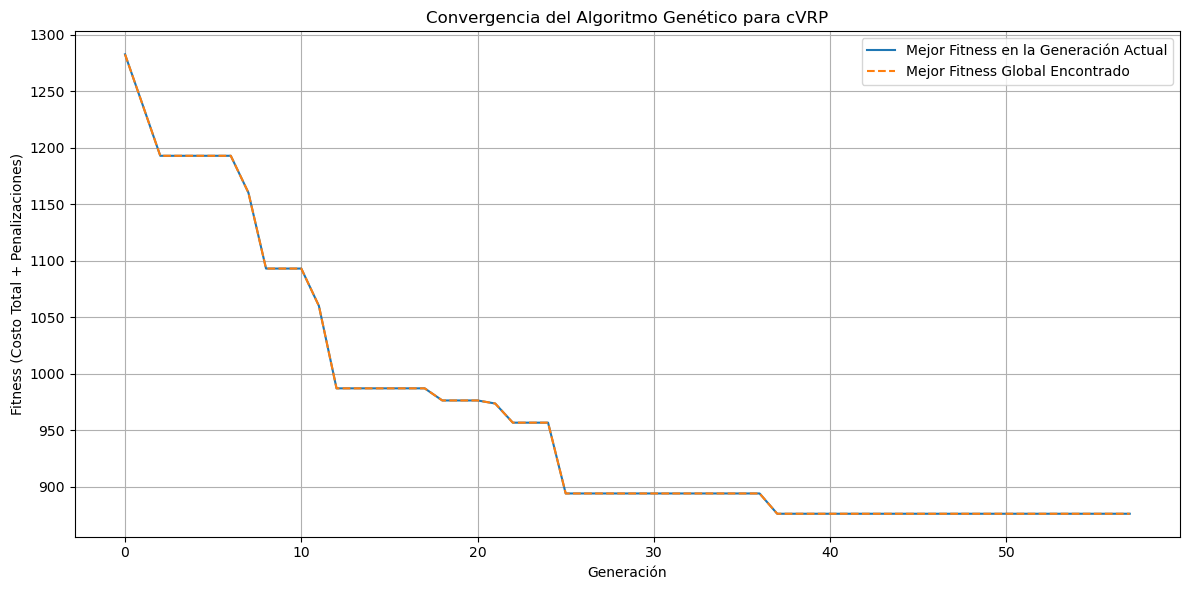

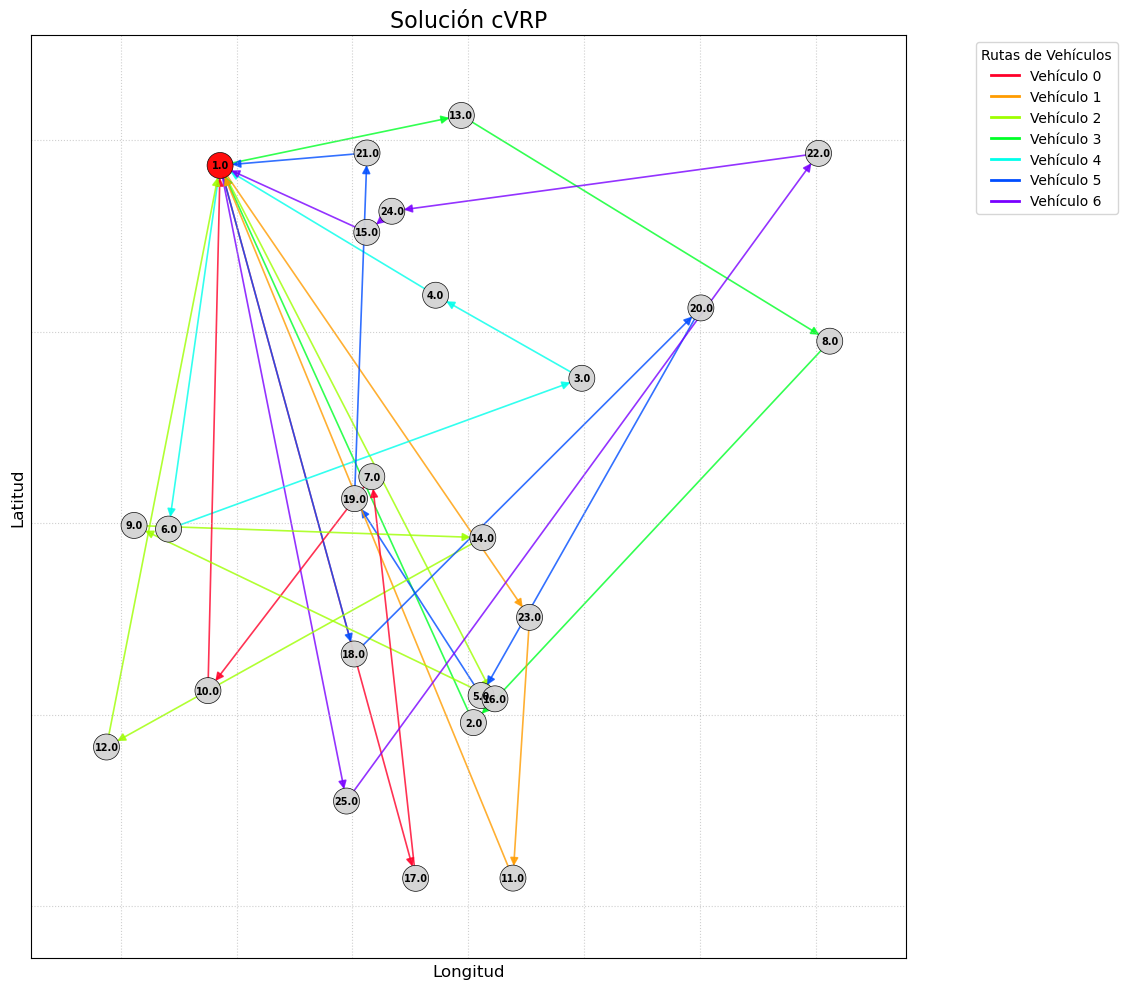

In [17]:
if __name__ == '__main__':
    num_total_nodes = df_nodes.shape[0]
    distance_matrix_data = np.random.rand(num_total_nodes, num_total_nodes) * 100
    np.fill_diagonal(distance_matrix_data, 0)
    for i in range(num_total_nodes):
        for j in range(i + 1, num_total_nodes):
            distance_matrix_data[j, i] = distance_matrix_data[i, j]

    demands_data = np.random.randint(5, 25, size=num_total_nodes)
    depot_idx_example = 0
    demands_data[depot_idx_example] = 0 

    num_vehicles_example = df_vehicles.shape[0]
    vehicle_capacities_data = [random.randint(40, 80) for _ in range(num_vehicles_example)]
    vehicle_ranges_data = [random.randint(300, 600) for _ in range(num_vehicles_example)]
    
    depot_node_indices_data = [depot_idx_example] 
    all_node_indices_data = list(range(num_total_nodes))

    print("Iniciando prueba de GeneticAlgorithmCVRP con datos de ejemplo...")
    
    ga_cvrp_instance = GeneticAlgorithmCVRP(
        distance_matrix=distance_matrix_data,
        demands=demands_data,
        vehicle_capacities=vehicle_capacities_data,
        vehicle_ranges=vehicle_ranges_data,
        depot_node_indices=depot_node_indices_data,
        all_node_indices=all_node_indices_data,
        population_size=300,   
        generations=500,      
        mutation_rate=0.25,
        crossover_rate=0.8,
        elitism_rate=0.1,
        tournament_size=3,
        penalty_factor_capacity=10000,
        penalty_factor_range=5000
    )

    best_solution_found, best_fitness_found = ga_cvrp_instance.solve(verbose=True, early_stopping_generations=20)

    if best_solution_found:
        print("\n--- Mejor Solución Encontrada ---")
        print(f"Fitness: {best_fitness_found:.2f}")
        for i, route in enumerate(best_solution_found):
            if i < len(vehicle_capacities_data) and i < len(vehicle_ranges_data): # Asegurar que el índice es válido
                route_demand = ga_cvrp_instance._calculate_route_demand(route)
                route_dist = ga_cvrp_instance._calculate_route_distance(route)
                print(f"  Vehículo {i} (Cap: {vehicle_capacities_data[i]}, Ran: {vehicle_ranges_data[i]}): {route} -> Demanda: {route_demand}, Dist: {route_dist:.2f}")
            else:
                print(f"  Vehículo {i}: Datos de capacidad/rango no disponibles para este índice.")

        ga_cvrp_instance.plot_convergence()
        ga_cvrp_instance.plot_solution_cvrp(df_nodes)
    else:
        print("\nNo se encontró una solución o la población/solución es None.")

# Comparación con soluciones previas

Comparar con las que obteniamos en la entrega pasada. 

# Análisis de escalabilidad

Revisar para los casos 2 y 3.

## Caso 2

In [12]:
df_clients_case2, df_depots_case2, df_vehicles_case2, df_nodes_case2, \
distance_matrix_case2, location_to_idx_map_case2, depot_ids_case2 = \
    load_data_and_calculate_distances(
        clients_file='caso_2/clients.csv',
        depots_file='caso_2/depots.csv',
        vehicles_file='caso_2/vehicles.csv'
    )

print("#"*15 + " CLIENTES, DEPOSITOS, VEHICULOS " + "#"*15)
print(f"[#] clientes {df_clients_case2.shape[0]}")
print(df_clients_case2.head(2), end="\n\n")

print(f"[#] depo {df_depots_case2.shape[0]}")
print(df_depots_case2.head(2), end="\n\n")

print(f"[#] vehic {df_vehicles_case2.shape[0]}")
print(df_vehicles_case2.head(2), end="\n\n")

print("#"*15 + " NODOS " + "#"*15)
print(df_nodes_case2.head(2))
print()

print("#"*15 + " MATRIZ DE DISTANCIAS " + "#"*15)
df_distance_matrix_case2 = pd.DataFrame(
    distance_matrix_case2, 
    index=df_nodes_case2['LocationID'], 
    columns=df_nodes_case2['LocationID']
)
print(df_distance_matrix_case2.head(2))
print()

############### CLIENTES, DEPOSITOS, VEHICULOS ###############
[#] clientes 9
   ClientID  LocationID  Demand  Longitude  Latitude
0         1          13      12 -74.196992  4.632553
1         2          14      15 -74.155037  4.601328

[#] depo 12
   DepotID  LocationID  Longitude  Latitude  Capacity
0        1           1 -74.081242  4.750212         8
1        2           2 -74.109934  4.536383        10

[#] vehic 6
   VehicleID   Capacity        Range
0          1  131.92114   145.852071
1          2  108.43562  1304.605971

############### NODOS ###############
   LocationID  Longitude  Latitude  Demand
0           1 -74.081242  4.750212       0
1           2 -74.109934  4.536383       0

############### MATRIZ DE DISTANCIAS ###############
LocationID        1         2          3          4          5          6   \
LocationID                                                                   
1            0.00000  23.85885   6.689038   3.525447  16.980968  12.007334   
2       

Iniciando prueba de GeneticAlgorithmCVRP con datos del caso 2...
Generation 20, Best Fitness: 571.24
Generation 40, Best Fitness: 507.11
Generation 60, Best Fitness: 507.11
Generation 80, Best Fitness: 507.11
Early stopping at gen 80.

Optimization complete. Overall Best Fitness: 507.11

--- Mejor Solución Encontrada (Caso 2) ---
Fitness: 507.11
  Vehículo 0 (Cap: 56, Ran: 590): [9, 7, 12] -> Demanda: 55, Dist: 91.14
  Vehículo 1 (Cap: 64, Ran: 393): [16, 14, 5, 6] -> Demanda: 62, Dist: 57.92
  Vehículo 2 (Cap: 71, Ran: 402): [4, 2, 18, 1, 3] -> Demanda: 69, Dist: 144.70
  Vehículo 3 (Cap: 77, Ran: 423): [19, 15, 11, 17, 20, 8] -> Demanda: 72, Dist: 152.49
  Vehículo 4 (Cap: 69, Ran: 362): [13] -> Demanda: 23, Dist: 53.89
  Vehículo 5 (Cap: 49, Ran: 573): [10] -> Demanda: 19, Dist: 6.98


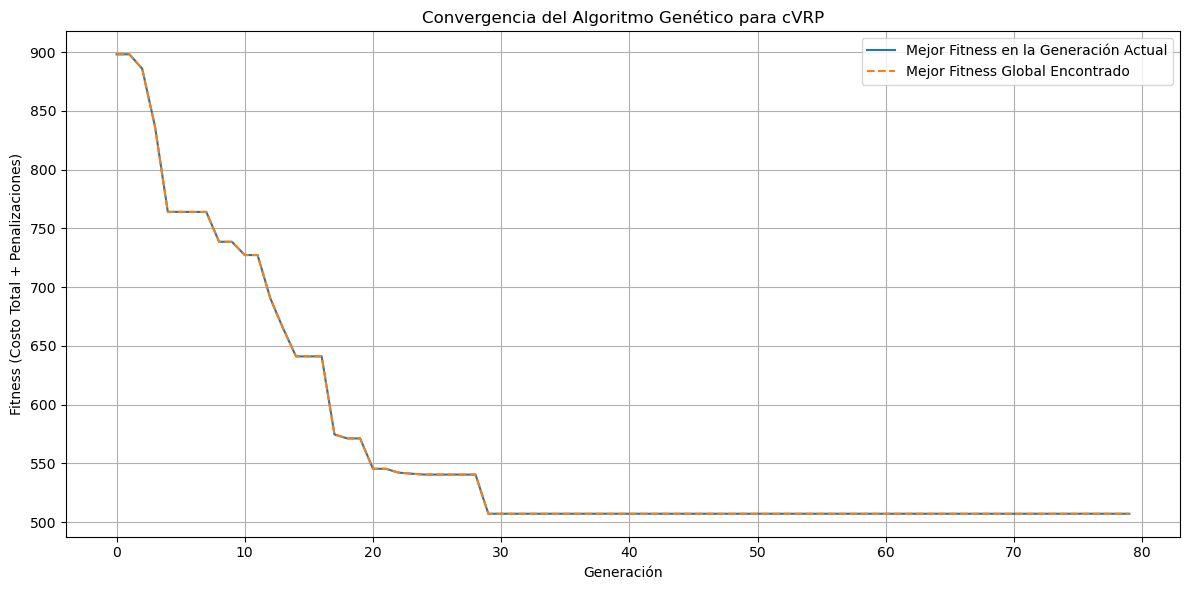

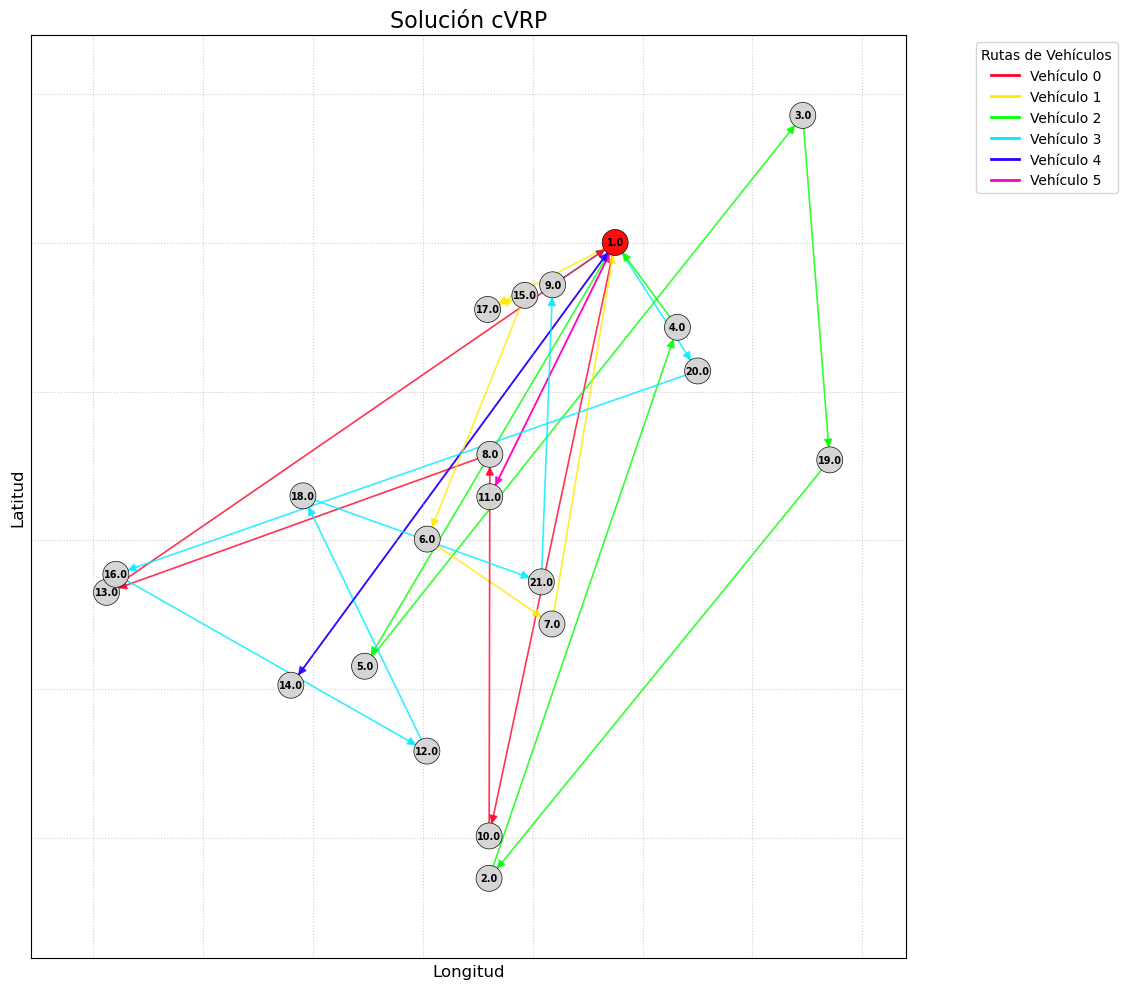

In [14]:
num_total_nodes_case2 = df_nodes_case2.shape[0]
distance_matrix_data_case2 = np.random.rand(num_total_nodes_case2, num_total_nodes_case2) * 100
np.fill_diagonal(distance_matrix_data_case2, 0)
for i in range(num_total_nodes_case2):
    for j in range(i + 1, num_total_nodes_case2):
        distance_matrix_data_case2[j, i] = distance_matrix_data_case2[i, j]

demands_data_case2 = np.random.randint(5, 25, size=num_total_nodes_case2)
depot_idx_example_case2 = 0 
demands_data_case2[depot_idx_example_case2] = 0 

num_vehicles_example_case2 = df_vehicles_case2.shape[0]
vehicle_capacities_data_case2 = [random.randint(40, 80) for _ in range(num_vehicles_example_case2)]
vehicle_ranges_data_case2 = [random.randint(300, 600) for _ in range(num_vehicles_example_case2)]

depot_node_indices_data_case2 = [depot_idx_example_case2] 
all_node_indices_data_case2 = list(range(num_total_nodes_case2))

print("Iniciando prueba de GeneticAlgorithmCVRP con datos del caso 2...")

ga_cvrp_instance_case2 = GeneticAlgorithmCVRP(
    distance_matrix=distance_matrix_data_case2,
    demands=demands_data_case2,
    vehicle_capacities=vehicle_capacities_data_case2,
    vehicle_ranges=vehicle_ranges_data_case2,
    depot_node_indices=depot_node_indices_data_case2,
    all_node_indices=all_node_indices_data_case2,
    population_size=300,   
    generations=300,      
    mutation_rate=0.25,
    crossover_rate=0.8,
    elitism_rate=0.1,
    tournament_size=3,
    penalty_factor_capacity=10000,
    penalty_factor_range=5000
)

best_solution_found_case2, best_fitness_found_case2 = \
    ga_cvrp_instance_case2.solve(
        verbose=True,
        early_stopping_generations=50
    )

if best_solution_found_case2:
    print("\n--- Mejor Solución Encontrada (Caso 2) ---")
    print(f"Fitness: {best_fitness_found_case2:.2f}")
    for i, route in enumerate(best_solution_found_case2):
        if i < len(vehicle_capacities_data_case2) and i < len(vehicle_ranges_data_case2):
            route_demand = ga_cvrp_instance_case2._calculate_route_demand(route)
            route_dist = ga_cvrp_instance_case2._calculate_route_distance(route)
            print(f"  Vehículo {i} (Cap: {vehicle_capacities_data_case2[i]}, Ran: {vehicle_ranges_data_case2[i]}): {route} -> Demanda: {route_demand}, Dist: {route_dist:.2f}")
        else:
            print(f"  Vehículo {i}: Datos de capacidad/rango no disponibles para este índice.")

    ga_cvrp_instance_case2.plot_convergence()
    ga_cvrp_instance_case2.plot_solution_cvrp(df_nodes_case2)
else:
    print("\nNo se encontró una solución válida para el caso 2.")

## Caso 3

# Visualización y evaluación